# **Visualisation et statistiques descriptives**
---

## Introduction<a class="anchor" id="partie1"></a>

Ce notebook contient les codes nécessaires à la visualisation et les statistiques descriptives de notre base de données.

## Sommaire

* [Introduction](#partie1)
* [Statistiques descriptives](#partie2)
    * [Visualisation et nettoyage des données manquantes](#partie21)
    * [Statistiques descriptives intra-pays](#partie22)
        * [Résumé statistique des variables](#partie221)
        * [Étude des corrélations](#partie222)
    * [Statistiques descriptives inter-pays](#partie23)
    * [Une première analyse exploratoire des séries temporelles](#partie24)
        * [Données du PIB](#partie241)
        * [Données des Working Hours](#partie242)
        * [Données des taux d'intérêt à long terme](#partie243)
        * [Données des taux d'intérêt à court terme](#partie244)
        * [Données du CPI](#partie235)
        * [Données de la croissance potentielle](#partie246)
* [Visualisation](#partie3)
    * [Données de PIB](#partie31)
    * [Données d'heures de travail](#partie32)


In [3]:
!pip install -r requirements.txt

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots

from Codes.scrpits_visualisations import (
    tracer_evolution
)


In [3]:
# Importation des données
#df = pd.read_excel("Données_produites/base_de_données_v1.xlsx")

#Pour voir les changements avec la suppression des données manquantes intermédiaires utiliser:
df = pd.read_excel("base_de_données_v1.xlsx")


# Indexation
df = df.set_index('Unnamed: 0')

## Statistiques descriptives <a class="anchor" id="partie2"></a>

### Visualisation et nettoyage des données manquantes <a class="anchor" id="partie21"></a>

Dans une volonté de rendre compte des valeurs manquantes à notre dataframe nous créons un dataframe qui comprend l'ensemble des valeurs manquantes 

In [ ]:
df_missing_binary = df.isnull().astype(int)
df_missing_binary

In [ ]:
df_nan = df.isna()
df_nan = pd.DataFrame({
    "TIME_PERIOD_WITH_NAN": df_nan.apply(lambda col: list(df.index[col]), axis = 0)
})
df_nan.to_csv("df_nan.csv", index=True, encoding="utf-8")
print(df_nan)

In [ ]:
# Définir la figure avec un affichage interactif
fig, ax = plt.subplots(figsize=(50, 80))

# Utiliser seaborn pour une meilleure visualisation sans grille
sns.heatmap(df_missing_binary, cmap="OrRd", cbar=False, linewidths=0, ax=ax, square=False)

# Ajouter un titre
ax.set_title("Matrice des valeurs manquantes (Rouge = Manquant)")

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Afficher la figure
plt.show()

In [6]:
#Pourcentage de données manquantes par variable
percentage_missing=((df_missing_binary.sum())/df_missing_binary.shape[0])*100

#On ne garde que les colonnes ayant des missing values
percentage_missing=percentage_missing[percentage_missing>0]
percentage_missing = percentage_missing.sort_values(ascending=False)

'''
Nous avons un problème avec l'Estonie, 85% des données pour les taux d'intérêt sont des valeurs manquantes
J'ai revérifié sur le site de l'OCDE et c'est un problème qui vient de leur bases de données. Comme c'est une 
un pourcentage considérable, on devrait peut-être retirer l'Estonie de notre analyse

Pour les données qui sont "entrecoupées" (on dirait un chemin de la route)--> c'est les Working Hours. On peut appliquer le même 
interpolation qu'on a faite pour construire le df. 

--> Voir tentative d'interpolation dans le notebook data.ipynb
Un problème persiste avec les données qui sont au début ou à la fin de la période temporelle, il faudra envisager
une autre méthode
'''
percentage_missing


NameError: name 'df_missing_binary' is not defined

### Statistiques descriptives intra-pays <a class="anchor" id="partie22"></a>

#### Résumé statistique des variables <a class="anchor" id="partie221"></a>

Nous allons tout d'abord effectuer des statistiques descriptives par pays des variables que nous avons collectées. Afin de mieux déterminer les effets de la politique monétaire et les chocs, nous avons privilégié une analyse centrée sur les périodes suivantes: 
- Avant 2008 (1995-2007)
- Après 2008 (2008-2019)
- Post-COVID (2020-2024)

Quelques lignes de code préliminaires

In [4]:
#Fonction qui construit un vecteur contenant le nom des variables
def variables_pays(pays):
    variable_pays=[f'CPI_{pays}',f'PIB_{pays}',f'LT_IR_{pays}',f'ST_IR_{pays}',f'WH_{pays}',f'P_Growth_{pays}']
    return(variable_pays)

In [5]:
#Création d'une copie de la base de données ayant pour index des DateTime
df_TS=df.copy()
df_TS.index = pd.PeriodIndex(df.index, freq='Q')  #conversion en PeriodIndex
df_TS.index = df_TS.index.to_timestamp() #Conversion en DateTime
print(type(df.index))

''' 
Ici je ne suis pas sûr:
- pour faire des analyses en séries temporelles, il faut que les index soient des datetime
- j'ai donc converti chaque trimestre en la première date de chaque trimestre. 
- pour des graphes, et pour transformer les sorties, on peut utiliser : df.index.strftime('%Y-Q%q')
- je ne sais pas s'il y a une meileure façon de faire

'''



<class 'pandas.core.indexes.base.Index'>


" \nIci je ne suis pas sûr:\n- pour faire des analyses en séries temporelles, il faut que les index soient des datetime\n- j'ai donc converti chaque trimestre en la première date de chaque trimestre. \n- pour des graphes, et pour transformer les sorties, on peut utiliser : df.index.strftime('%Y-Q%q')\n- je ne sais pas s'il y a une meileure façon de faire\n\n"

In [9]:
#On divise le df en 3 (correspondant à chaque période)
df_TS_before_2008 = df_TS.loc[df_TS.index < '2008-01-01'].copy()
df_TS_after_2008 = df_TS.loc[(df_TS.index >= '2008-01-01') & (df_TS.index<'2020-01-01')].copy()
df_TS_after_2020 = df_TS.loc[df_TS.index >= '2020-01-01'].copy()


In [13]:
#Synthèse avant 2008
df_TS_before_2008.describe()

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
count,48.000000,52.000000,52.000000,52.000000,52.000000,52.000000,48.000000,52.000000,52.000000,52.000000,...,52.000000,34.000000,48.000000,52.000000,48.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,77.677431,55422.380769,4.915120,3.381302,39.175000,0.588545,77.507639,67065.700000,4.987885,3.377841,...,3.258474,1.475143,37.341146,0.480981,74.568750,428909.325000,5.553535,5.540052,36.325000,0.652542
std,4.487121,7943.450285,1.049803,0.870063,0.765782,0.063717,5.122201,10310.457162,1.128353,0.910077,...,0.773375,1.055814,0.204503,0.124752,3.874414,92803.692986,1.271353,1.140100,0.517014,0.170744
min,71.553333,43186.600000,3.222567,2.062951,37.400000,0.465652,70.003333,53331.500000,3.250000,2.062951,...,1.944333,0.136264,37.000000,0.213238,68.100000,248722.500000,4.182400,3.569803,35.100000,0.243172
25%,73.363333,48478.100000,4.152508,2.670813,38.575000,0.552114,72.515833,57891.700000,4.179167,2.670813,...,2.712750,0.645877,37.137500,0.422266,71.625000,367466.425000,4.658075,4.615929,36.025000,0.598589
50%,77.333333,55025.000000,4.818650,3.424899,39.350000,0.576752,77.433333,66230.800000,4.850000,3.359787,...,3.079500,1.270656,37.350000,0.504647,73.883333,454437.250000,5.067450,5.579657,36.500000,0.676162
75%,81.452500,60350.750000,5.558466,3.881442,39.812500,0.642478,81.423333,74390.375000,5.599167,3.855243,...,3.682750,2.279268,37.550000,0.536039,77.133333,487710.375000,5.877325,6.338393,36.600000,0.768325
max,86.650000,74092.600000,7.627367,5.043334,40.200000,0.685113,87.360000,90340.200000,8.293333,5.706666,...,5.275333,3.315616,37.600000,0.669791,82.600000,572200.400000,8.661467,7.667380,37.200000,0.836220


In [14]:
#Synthèse après 2008
df_TS_after_2008.describe()

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
count,48.000000,48.00000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,97.477431,83171.20000,1.930519,0.648115,36.118750,0.255118,98.602292,101152.591667,2.180417,0.648115,...,0.794306,-0.157147,36.770312,0.437978,97.200000,550832.908333,2.392842,1.095422,35.829167,0.300471
std,6.184689,9290.44164,1.469795,1.364772,0.996303,0.054965,5.806349,11291.276103,1.555218,1.364772,...,1.058372,0.752367,0.570696,0.050537,7.187321,71293.483919,1.145375,1.384973,0.314851,0.185536
min,87.333333,67659.60000,-0.259933,-0.402952,34.400000,0.153378,88.323333,82764.900000,-0.173333,-0.402952,...,-0.776333,-0.898711,35.800000,0.332407,82.933333,426623.600000,0.668700,0.294467,35.100000,0.036136
25%,91.796667,75482.85000,0.602917,-0.309530,35.400000,0.220427,93.687500,92738.725000,0.748333,-0.309530,...,-0.065833,-0.768329,36.275000,0.423136,91.500000,492246.375000,1.463375,0.531755,35.600000,0.106101
50%,98.540000,81633.80000,1.844000,0.209115,36.000000,0.240358,99.131667,99853.300000,2.228334,0.209115,...,0.626167,-0.058552,36.850000,0.439983,99.350000,553055.700000,2.044883,0.654960,35.800000,0.298736
75%,102.096667,90841.65000,3.166258,0.911322,36.700000,0.311261,102.830000,108813.650000,3.722500,0.911322,...,1.584750,0.090904,37.218750,0.460077,101.625000,600915.300000,3.381450,0.832834,36.100000,0.485022
max,108.110000,103620.40000,4.573300,4.981791,38.700000,0.336127,108.136667,129471.500000,4.663333,4.981791,...,3.272000,2.331029,37.900000,0.547626,108.433333,677282.100000,4.907267,5.891547,36.400000,0.553988


In [18]:
#Synthèse après 2020
df_TS_after_2020.describe()

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
count,20.000000,19.000000,20.000000,20.000000,20.000000,8.000000,20.000000,19.000000,20.000000,20.000000,...,20.000000,20.000000,20.00000,8.000000,4.000000,3.000000,20.000000,20.000000,20.00000,8.000000
mean,121.120333,108639.494737,1.465260,1.273871,33.730000,0.189516,120.157833,135803.721053,1.517000,1.273871,...,0.334517,0.230374,36.03000,0.353064,108.733333,585008.666667,2.362302,2.467667,35.67500,0.198579
std,10.566285,10889.490710,1.491470,1.959045,0.855385,0.058834,9.263672,15322.306344,1.472258,1.959045,...,0.652367,1.036428,0.59921,0.028383,0.272166,56536.284370,1.676976,2.279396,0.07864,0.089147
min,108.110000,87490.900000,-0.410600,-0.566377,31.800000,0.134482,108.076667,107165.400000,-0.370000,-0.566377,...,-0.632667,-0.764773,34.00000,0.326515,108.466667,530595.800000,0.251367,0.040000,35.40000,0.115189
25%,110.715833,100599.500000,-0.081558,-0.524278,33.000000,0.134482,110.260000,124104.250000,0.021667,-0.524278,...,-0.300667,-0.712877,35.90000,0.326515,108.516667,555786.700000,0.688967,0.133333,35.70000,0.115189
50%,121.185000,112228.500000,1.788917,0.090037,33.850000,0.189516,122.868333,139202.400000,1.828333,0.090037,...,0.394667,-0.308853,36.10000,0.353064,108.733333,580977.600000,2.349900,1.831667,35.70000,0.198579
75%,131.275833,117810.000000,2.869083,3.406169,34.175000,0.244550,127.757500,147895.800000,2.902500,3.406169,...,0.860333,1.206598,36.40000,0.379613,108.950000,612215.100000,4.004400,4.821667,35.70000,0.281968
max,135.183333,122280.300000,3.199733,3.957456,35.400000,0.244550,133.383333,158085.700000,3.226667,3.957456,...,1.310000,1.752424,36.80000,0.379613,109.000000,643452.600000,4.462300,5.513333,35.70000,0.281968


### Statistiques descriptives inter-pays <a class="anchor" id="partie23"></a>

#### Statistiques par types de variables <a class="anchor" id="partie231"></a>

In [6]:
# Réglages d'affichage
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)    
pd.set_option('display.width', 1000) 

##### CPI <a class="anchor" id="partie2311"></a>

In [ ]:
colonnes_CPI = [colonne for colonne in df_TS.columns if colonne.startswith('CPI')]
CPI = df[colonnes_CPI]
CPI.describe()

On remarque que les moyennes sont assez similaires aux alentours comprises entre 91 et 95 pour la plupart des pays, on a cependant certains pays pour lesquels elles sont en dessous, avec notamment l'Islande et la Roumanie sous les 80 et la Suisse est la seule au delà des 100. On remarque aussi des écart-types plus élevées (au-dessus des 20) pour les pays d'Europe de l'Est et du Nord-est (et l'Islande), contre des écart-types compris entre 13 et 17 pour la plupart des autres pays, la Suisse faisant exception avec un écart-types de 2,33. Ces différences s'expliquent par des évolutions bien plus fortes depuis les années 1995 par ces pays de l'Est. les graphes ci-dessous illustrent cela.

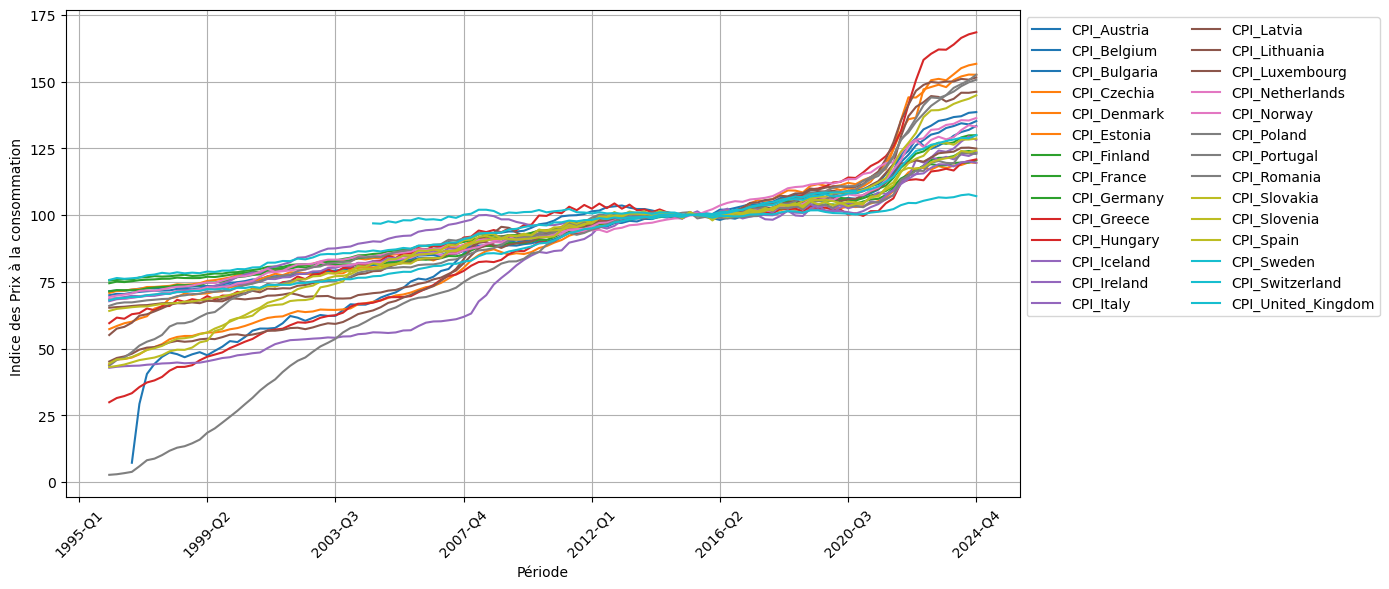

In [ ]:
tracer_evolution(CPI, xlabel ="Période",ylabel = "Indice des Prix à la consommation ")

Le graphique ci-dessus montre l'évolution de tous les pays et on peut observer la tendance haussière globale, pour expliciter le phénomènes de distinction on sépare en deux groupes nos pays et on les plot séparément 

In [26]:
# On sépare en deux groupe selon la valeur de l'écart-type
CPI_description = CPI.describe()
std_values = CPI_description.loc['std']
CPI_groupe_1_indices = std_values[std_values < 18].index  
CPI_groupe_2_indices = std_values[std_values > 18].index
CPI_groupe_1 = CPI[CPI_groupe_1_indices]
CPI_groupe_2 = CPI[CPI_groupe_2_indices]

# Ajout de la valeur moyenne
Moyenne_CPI_1 = CPI_groupe_1.mean(axis=1)
CPI_groupe_1['CPI_Mean'] = Moyenne_CPI_1
Moyenne_CPI_2 = CPI_groupe_2.mean(axis=1)
CPI_groupe_2['CPI_Mean'] = Moyenne_CPI_2

CPI_Moyenne = pd.DataFrame()
CPI_Moyenne["CPI_Mean_group_1"] = Moyenne_CPI_1
CPI_Moyenne["CPI_Mean_group_2"] = Moyenne_CPI_2

/tmp/ipykernel_60476/576143111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_groupe_1['CPI_Mean'] = Moyenne_CPI_1
/tmp/ipykernel_60476/576143111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_groupe_2['CPI_Mean'] = Moyenne_CPI_2


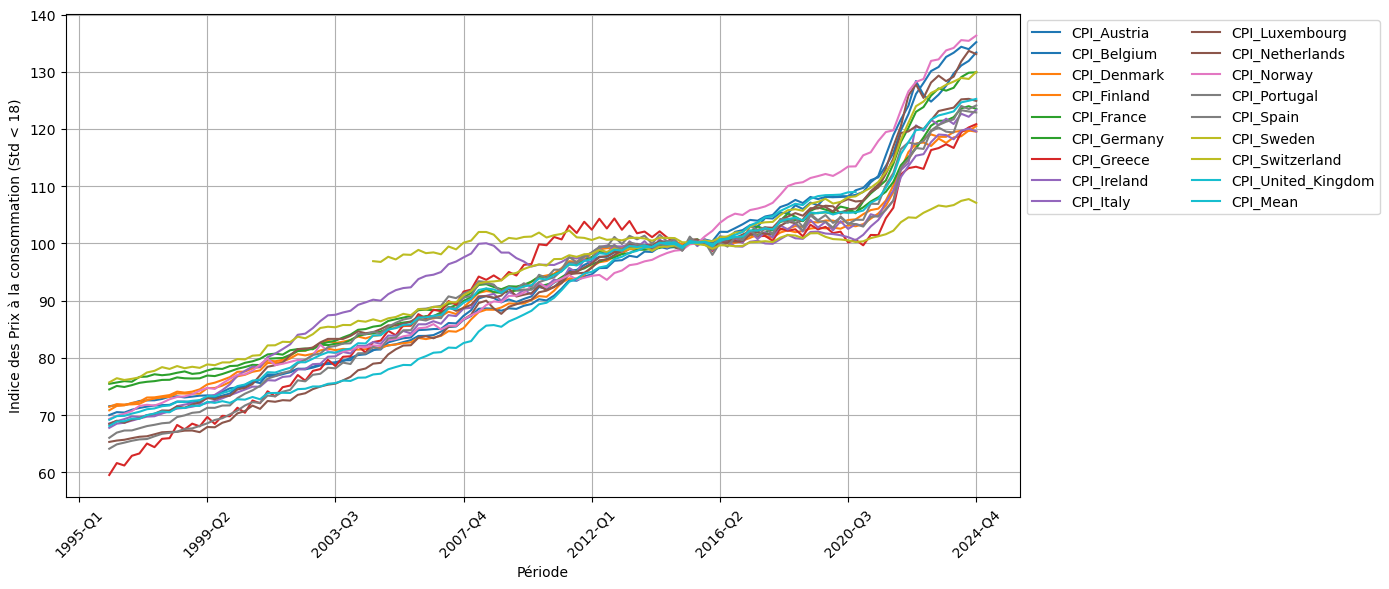

In [24]:
tracer_evolution(CPI_groupe_1, xlabel ="Période",ylabel = "Indice des Prix à la consommation (Std < 18)")

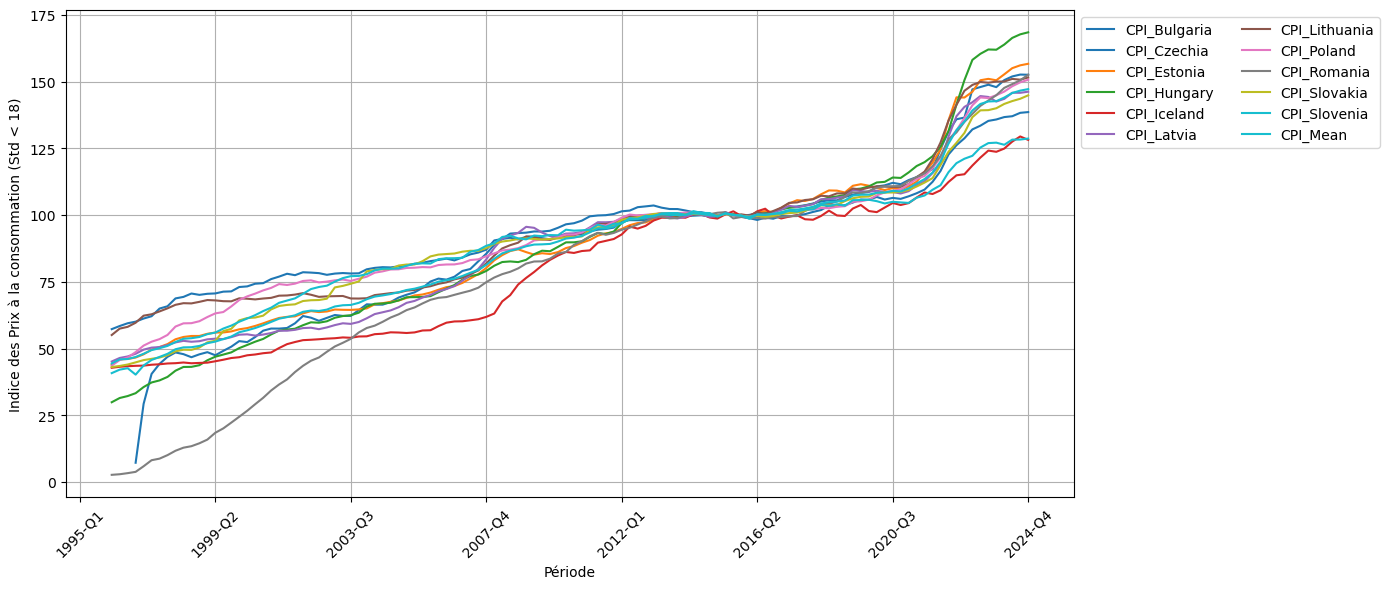

In [25]:
tracer_evolution(CPI_groupe_2, xlabel ="Période",ylabel = "Indice des Prix à la consommation (Std < 18)")

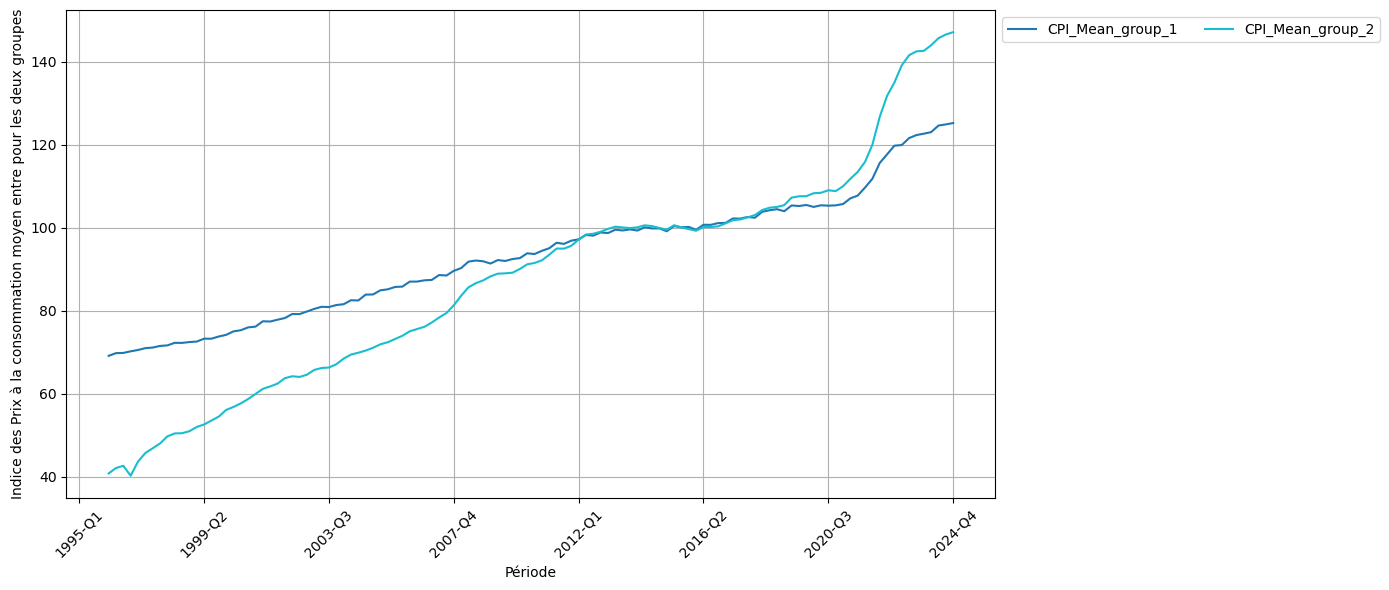

In [27]:
tracer_evolution(CPI_Moyenne, xlabel ="Période",ylabel = "Indice des Prix à la consommation moyen entre pour les deux groupes")

On observe mieux les différences entre le groupe 1 et le groupe 2, avec une croissance de CPI moyenne plus élevée dans le second groupe. On va essayer de voir si la différence entre ces deux groupes est aussi marquée pour les autres variables.

#### Étude des corrélations <a class="anchor" id="partie222"></a>

Correlations\
Idée: nous allons étudier les correlations entre plusieurs variables de 4 pays (corrélations à l'intérieur du même pays)

In [ ]:
France=variables_pays('France')
Germany=variables_pays('Germany')
Denmark=variables_pays('Denmark')
Romania=variables_pays('Romania')

plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
sns.heatmap(df[France].corr())
plt.title("Matrice de corrélation des variables de la France")

plt.subplot(2,2,2)
sns.heatmap(df[Germany].corr())
plt.title("Matrice de corrélation des variables de l'Allemagne")

plt.subplot(2,2,3)
sns.heatmap(df[Denmark].corr())
plt.title("Matrice de corrélation des variables du Danemark")

plt.subplot(2,2,4)
sns.heatmap(df[Romania].corr())
plt.title("Matrice de corrélation des variables de la Roumanie")



### Une première analyse exploratoire des séries temporelles <a class="anchor" id="partie24"></a>

Pour chaque variable, nous allons déterminer  le tendances et les saisonalités des séries temporelles. Compte tenu du nombre de pays dans notre échantillon, nous allons tout d'abord faire cette analyse pour la France et pour les principaux pays d'Europe. 

#### Données du PIB <a class="anchor" id="partie241"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['PIB_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("PIB de la France")
plt.title("Évolution du PIB de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['PIB_France'].resample('Q').mean())
plt.show()

A première vue, il semblerait qu'il n'y ait pas de saisonalité pour le PIB

Ce qui suit est un brouillon qui nous sera utile lorsque nous aurons déterminé la stationnarité de la série temporelle

In [ ]:
#Autocorrélation (ACF)
plt.figure(figsize=(14,6))
tsaplots.plot_acf(df_TS['PIB_France'], lags=30)
plt.title("Fonction d'autocorrélation du PIB de la France")
plt.show()

#Remarque: on n'a pas encore vérifié que la série est stationnaire, donc l'intévalle de confiance peut-être biaisé


In [ ]:
#Autocorrélation partielle (PACF)
plt.figure(figsize=(14,6))
tsaplots.plot_pacf(df_TS['PIB_France'], lags=30)
plt.title("Fonction d'autocorrélation partielle du PIB de la France")
plt.show()

#### Données des Working Hours <a class="anchor" id="partie242"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['WH_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Nombre d'heures travaillées par semaine")
plt.title("Évolution du nombre d'heures travaillées en France(1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

La tendance décroissance du nombre d'heures travaillées en France peut s'expliquer par
- l'interpolation faite entre 1995-2002 (données annuelles disponibles uniquement)
- la mise en place des lois (nombre d'heures qui passe de 39 à 35)

#### Données des taux d'intérêt à long terme <a class="anchor" id="partie243"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['LT_IR_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Taux d'intérêt (Long Terme) de la France")
plt.title("Évolution du taux d'intérêt (long terme) de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['LT_IR_France'].resample('Q').mean())
plt.show()

#### Données des taux d'intérêt à court terme <a class="anchor" id="partie244"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['ST_IR_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Taux d'intérêt (court terme)")
plt.title("Évolution du taux d'intérêt (court terme) de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['ST_IR_France'].resample('Q').mean())
plt.show()

#### Données du CPI <a class="anchor" id="partie245"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['PIB_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("CPI")
plt.title("Évolution du du CPI de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['PIB_France'].resample('Q').mean())
plt.show()

#### Données de la croissance potentielle <a class="anchor" id="partie246"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['P_Growth_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Croissance potentielle")
plt.title("Évolution de la croissance potentielle de la France (1995-2021)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

## Visualisation <a class="anchor" id="partie3"></a>

### Données de PIB <a class="anchor" id="partie31"></a>

Pour notre rendu de mi-parcours nous avons présenté les évolutions des PIB en France et dans les principaux pays d'Europe. Nous faisons d'abord celui de la France.

In [ ]:
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df.index, df['PIB_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("PIB de la France")
plt.title("Évolution du PIB de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df.index[indices],rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

Et ensuite pour l'Europe

In [ ]:
selected_countries = ['PIB_Germany', 'PIB_France', 'PIB_United_Kingdom','PIB_Spain', 'PIB_Italy', 'PIB_Netherlands', 'PIB_Switzerland']

df_selected = df[selected_countries]

colors = plt.cm.get_cmap("tab10", len(df_selected.columns))  # Utilisation d'une palette de couleurs
plt.figure(figsize=(14, 6))

for i, country in enumerate(df_selected.columns): #enumerate permet de sélectionner l'élément et son indice
    plt.plot(df_selected.index, df_selected[country], label=country, color=colors(i))

# Personnalisation du graphique
plt.xlabel("Période")
plt.ylabel("PIB en Millions")
plt.title("Principaux PIB trimestriels en Europe ")

# Indicage
num_ticks = 8 
indices = np.linspace(0, len(df_selected.index) - 1, num_ticks, dtype=int)  
plt.xticks(df_selected.index[indices], rotation=45) 

# Affichage 
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)  # Légende en dehors du graphique
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) #permet de ne pas avoir d'écriture scientifique
plt.show()


### Données d'heures travaillées <a class="anchor" id="partie32"></a>

Voici l'évolution des heures travaillées en France.

In [ ]:
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df.index, df['WH_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Heures travaillées en France")
plt.title("Évolution des heures travaillées en France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 10 
indices = np.linspace(0, len(df.index) - 1, num_ticks, dtype=int)
plt.xticks(df.index[indices], rotation=45)
plt.grid(True)
plt.show()